In [1]:
import requests
import json
import csv
import pandas as pd
from time import sleep
from dotenv import load_dotenv
from bs4 import BeautifulSoup
from openai import AzureOpenAI
import os

In [2]:
load_dotenv()

API_KEY = os.getenv("SERPHOUSE_API_KEY")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_DEPLOYMENT")

In [8]:
payload = {
    "data":{
    "q": "pfizer",
    "domain": "google.com",
    "loc": "United States",
    "lang": "en",
    "device": "desktop",
    "serp_type": "web",
    }
}

In [4]:
url = "https://api.serphouse.com/serp/live"
headers={
    'accept': 'application/json',
    'content-type': 'application/json',
    'authorization': f"Bearer {API_KEY}"
}

In [9]:
response = requests.post(url, headers=headers, json=payload)

Status Code: 200

Response JSON:
{
  "status": "success",
  "msg": "Completed",
  "results": {
    "search_metadata": {
      "id": 212121881,
      "status": "success",
      "created_at": "2025-10-15T04:54:24.000000Z",
      "processed_at": "2025-10-15 04:54:24"
    },
    "search_parameters": {
      "domain": "google.com",
      "lang": "en",
      "country": "US",
      "location": "United States",
      "q": "pfizer",
      "device": "desktop",
      "url": "https://www.google.com/search?q=pfizer&uule=w+CAIQICINVW5pdGVkIFN0YXRlcw==&hl=en&gl=US&num=10&ie=UTF-8",
      "page": "1",
      "num": 10,
      "ie": "UTF-8"
    },
    "results": {
      "search_information": [
        {
          "total_results": "38,900,000",
          "time_taken_displayed": "0.53"
        }
      ],
      "top_stories": [
        {
          "image": "",
          "title": "Pfizer CEO says US pharma industry needs to collaborate with China",
          "link": "https://finance.yahoo.com/news/pfizer-ceo
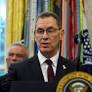
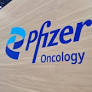
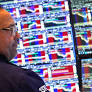
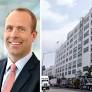

In [10]:
print("Status Code:", response.status_code)
print("\nResponse JSON:")
data = response.json()
print(json.dumps(data, indent=2))

In [11]:
search_results = data.get('results', {}).get('results', {})

In [12]:
top_stories_data = []
if 'top_stories' in search_results:
    for story in search_results['top_stories']:
        top_stories_data.append({
            'title': story.get('title'),
            'link': story.get('link')
})

In [13]:
organic_data = []
if 'organic' in search_results:
    for result in search_results['organic']:
        organic_data.append({
            'title': result.get('title'),
            'link': result.get('link'),
            'snippet': result.get('snippet')
})

In [14]:
print("Top Stories:")
for story in top_stories_data:
    print(f"Title: {story['title']}")
    print(f"Link: {story['link']}\n")

Top Stories:
Title: Pfizer CEO says US pharma industry needs to collaborate with China
Link: https://finance.yahoo.com/news/pfizer-ceo-says-us-pharma-025906152.html

Title: Pfizer scores again in HER2-positive breast cancer, this time with Seagen's Tukysa
Link: https://www.fiercepharma.com/pharma/pfizer-scores-again-her2-positive-breast-cancer-time-seagen-tukysa

Title: Pfizer (PFE) Receives a Hold from Bernstein
Link: https://www.theglobeandmail.com/investing/markets/stocks/PFE-N/pressreleases/35430231/pfizer-pfe-receives-a-hold-from-bernstein/

Title: Värde Partners Refis Former Brooklyn Pfizer Property With $125M Loan
Link: https://commercialobserver.com/2025/10/brooklyn-pfizer-industrial-property/



In [15]:
print("Organic:")
for result in organic_data:
    print(f"Title: {result['title']}")
    print(f"Link: {result['link']}")
    print(f"Snippet: {result['snippet']}\n")

Organic:
Title: Pfizer: One of the world&#39;s premier biopharmaceutical companies
Link: https://www.pfizer.com/
Snippet: About · Starting with Charles Pfizer inventing an almond-flavored antiparasite medicine in 1849, our people have always been innovators and trailblazers, ...

Title: Pfizer
Link: https://en.wikipedia.org/wiki/Pfizer
Snippet: Pfizer Inc is an American multinational pharmaceutical and biotechnology corporation headquartered at The Spiral in Manhattan, New York City.

Title: Pfizer Inc. (PFE)
Link: https://finance.yahoo.com/quote/PFE/
Snippet: Pfizer is one of the world's largest pharmaceutical firms, with annual sales of roughly $60 billion.

Title: Pfizer Pro
Link: https://www.pfizerpro.com/
Snippet: No information is available for this page.

Title: Pfizer Inc PFE:NYSE - Stock Price, Quote and News
Link: https://www.cnbc.com/quotes/PFE
Snippet: Pfizer Inc. is a research-based, global biopharmaceutical company. The Company is engaged in the discovery, development, ma

In [16]:
all_sources = organic_data + top_stories_data
unique_urls = list(set(item['link'] for item in all_sources if item.get('link')))

In [17]:
def scrape_url(url: str) -> str | None:
    """Scrapes the text content from a given URL."""
    print(f"  Scraping: {url}")
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        main_content = soup.find('main') or soup.find('article') or soup.find('body')
        return main_content.get_text(separator=' ', strip=True) if main_content else None
    except requests.RequestException as e:
        print(f"    Error scraping {url}: {e}")
        return None

In [18]:
scraped_content = []
for url in unique_urls[:10]:  # Limit to first 10 URLs to avoid timeout
    content = scrape_url(url)
    if content:
        scraped_content.append(f"--- CONTENT FROM {url} ---\n{content}")

full_context = "\n\n".join(scraped_content)
print(full_context[:1000])  # Print first 1000 characters of the context

  Scraping: https://www.pfizerpro.com/
  Scraping: https://finance.yahoo.com/quote/PFE/
  Scraping: https://www.theglobeandmail.com/investing/markets/stocks/PFE-N/pressreleases/35430231/pfizer-pfe-receives-a-hold-from-bernstein/
  Scraping: https://finance.yahoo.com/news/pfizer-ceo-says-us-pharma-025906152.html
  Scraping: https://en.wikipedia.org/wiki/Pfizer
  Scraping: https://www.pfizer.com/
  Scraping: https://commercialobserver.com/2025/10/brooklyn-pfizer-industrial-property/
  Scraping: https://www.cnbc.com/quotes/PFE
  Scraping: https://www.fiercepharma.com/pharma/pfizer-scores-again-her2-positive-breast-cancer-time-seagen-tukysa
    Error scraping https://www.fiercepharma.com/pharma/pfizer-scores-again-her2-positive-breast-cancer-time-seagen-tukysa: 403 Client Error: Forbidden for url: https://www.fiercepharma.com/pharma/pfizer-scores-again-her2-positive-breast-cancer-time-seagen-tukysa
--- CONTENT FROM https://www.pfizerpro.com/ ---
Something went wrong We encountered an unexp

In [19]:
print(full_context)

--- CONTENT FROM https://www.pfizerpro.com/ ---
Something went wrong We encountered an unexpected error, we encourage you to try again later. We're here to help Should you have additional questions please contact PfizerPro customer service. Representatives are available: Monday-Friday 8:00am to 9:00pm Eastern time Call 1 (800) 505-4426 PP-UNP-USA-5796 Order samples Unable to confirm your eligibility Unfortunately, your registration is incomplete and we are unable to confirm your eligibility for sample ordering. To gain access please enter your professional information within your account. Open your account We're here to help Should you need further support updating your account information, please contact PfizerPro customer service. Representatives are available: Monday-Friday 8:00am to 9:00pm Eastern time Call 1 (800) 505-4426 ​​​​​​​PP-UNP-USA-5796 Order samples Thank you for expressing interest in Pfizer samples. Currently there are no samples available to order. Samples renew perio

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import WebDriverException
from bs4 import BeautifulSoup
import time

# Helper set to track visited URLs
visited = set()

def scrape_page(driver, url, base_url):
    if url in visited or not url.startswith(base_url):
        return
    visited.add(url)
    try:
        driver.get(url)
        time.sleep(2)  # Allow JS to load, adjust if needed
        soup = BeautifulSoup(driver.page_source, "html.parser")
        print(f"\nScraped: {url}\nContent:")
        print(soup.prettify()[:2500])  # Change this to how you want to store/process content

        # Find all links on the page
        links = [a.get('href') for a in soup.find_all('a', href=True)]
        full_links = []
        for link in links:
            if link.startswith('http'):
                full_links.append(link)
            elif link.startswith('/'):
                full_links.append(base_url.rstrip('/') + link)
        # Recursively scrape discovered links
        for link in full_links:
            scrape_page(driver, link, base_url)
    except WebDriverException as e:
        print(f"Error scraping {url}: {e}")

if __name__ == "__main__":
    # Setup Chrome WebDriver
    driver = webdriver.Chrome()  # Ensure chromedriver is installed and in PATH

    start_url = "https://www.pfizer.com/"  # Replace with your actual site
    base_url = "https://www.pfizer.com"   # Replace with your site's base domain

    scrape_page(driver, start_url, base_url)
    driver.quit()
